Guide obtained courtesy of https://swaruplab.bio.uci.edu/tutorial/snRNA-essentials/snRNA-essentials.html <br>
<h5>Setup</h5>
This is simply loading the needed libraries, and indicating the directory containing the matrix.mtx, features.tsv, and barcodes.tsv to create a Seurat Object.


In [24]:
##Load in required packages
library(dplyr)
library(Seurat)
library(patchwork)

In [25]:
getwd()
pbmc.data <- Read10X(data.dir = "pbmc3k_filtered_gene_bc_matrices/filtered_gene_bc_matrices/hg19/")
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc                

[1] "/home/misumi/Seurat tutorial"

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)
 1 layer present: counts

<h5>QC Filtering</h5>
* Too few features may indicate low quality cells or empty droplets. <br>
* Too many features may indicate multiplets.<br>
* Too many mitochondrial reads can indicate low-quality or dying cells <br>
<br>
We are employing minimum and maximum thresholds of 200 and 2500, along with a 5% maximum threshold 

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


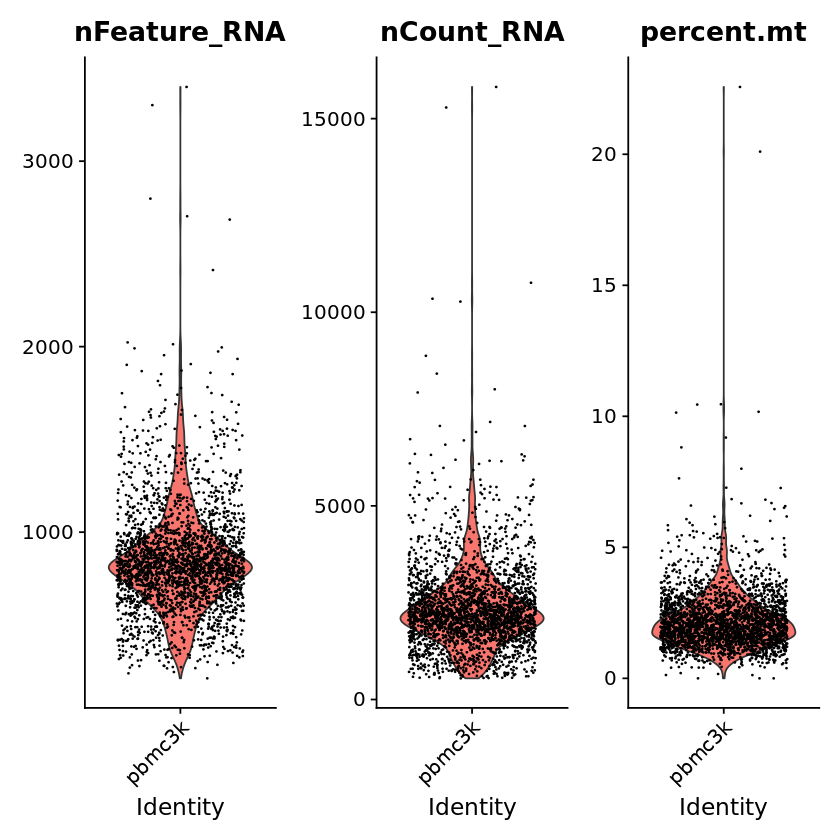

In [26]:
#Creating new feature for mitochondrial genes 
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

# Visualize QC metrics as a violin plot
# nFeature_RNA = total genes, nCount_RNA = total reads
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

pbmc_filtered <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)


<h5>Normalization</h5>
We will be using default parameters

In [27]:
pbmc_filtered <- NormalizeData(pbmc_filtered, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



<h5>Feature Selection</h5>
This step involves subsetting genes exhibiting high cell-to-cell variability.

Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


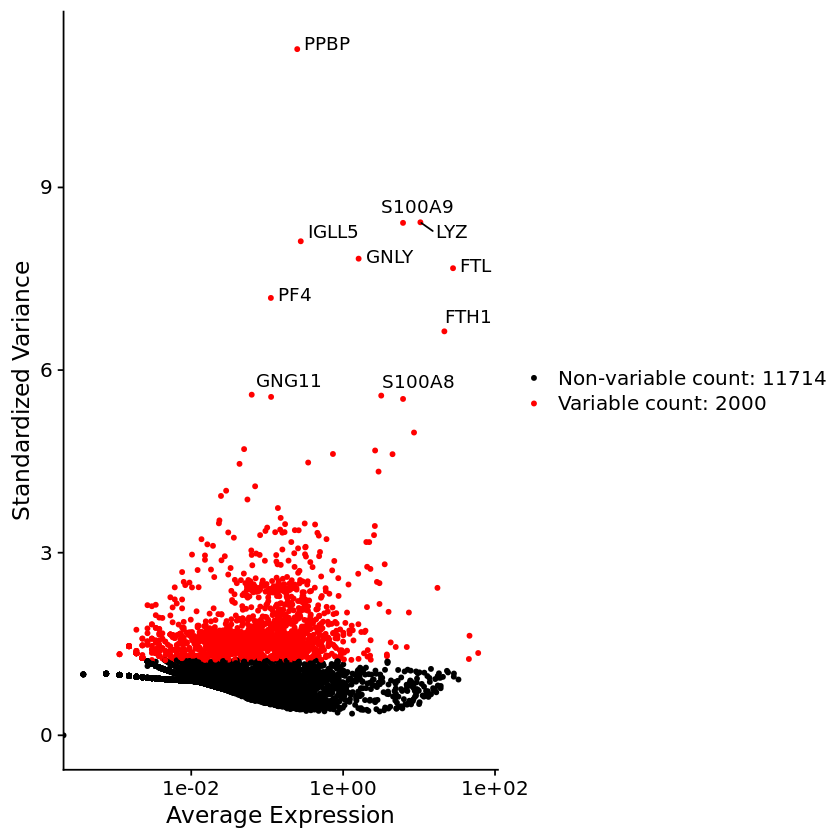

In [28]:
pbmc_filtered <- FindVariableFeatures(pbmc_filtered, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc_filtered), 10)

# plot variable features with and without labels
plot <- VariableFeaturePlot(pbmc_filtered)
plot_labled <- LabelPoints(plot = plot, points = top10, repel = TRUE)
plot_labled

<h5>Scale and Center Data</h5>
You can read more about this process here: https://satijalab.org/seurat/reference/scaledata. Gene expression is shifted until mean expression across all cells is 0, and then scaled so that variance across cells is 1.

In [29]:
# Get gene names as a vector
all.genes <- rownames(pbmc_filtered)
# Apply scaling using gene names as features.
pbmc_filtered <- ScaleData(pbmc_filtered, features = all.genes)

Centering and scaling data matrix



<h5>Linear Dimensional Reduction</h5>
This step involves a PCA transformation and visualization through VizDimReduction(), DimPlot(), and DimHeatmap().

In [30]:
pbmc_filtered <- RunPCA(pbmc_filtered, features = VariableFeatures(object = pbmc_filtered))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

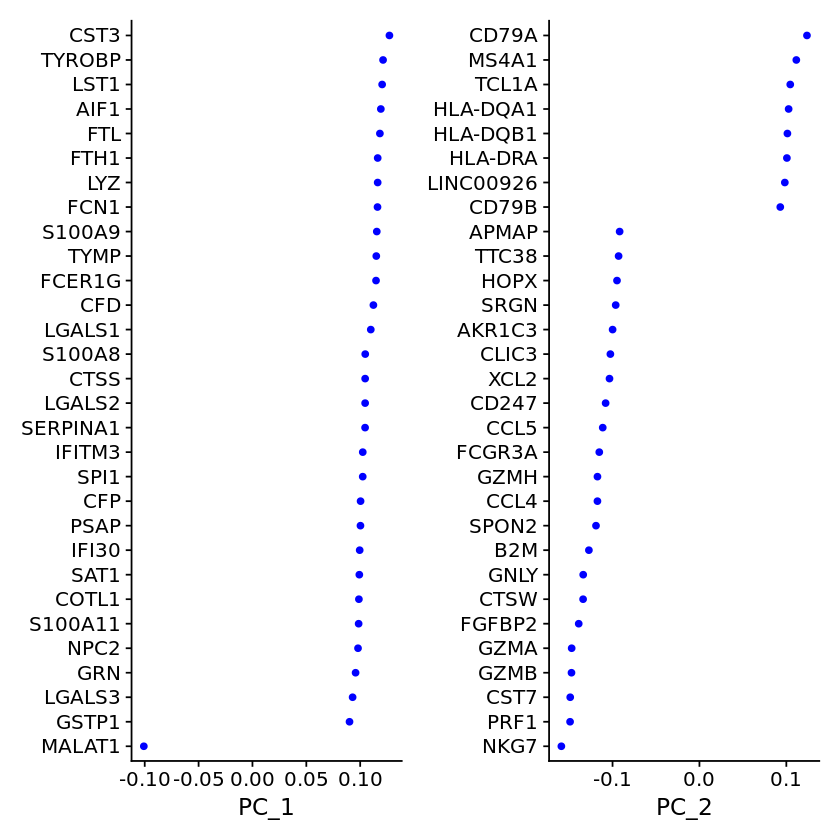

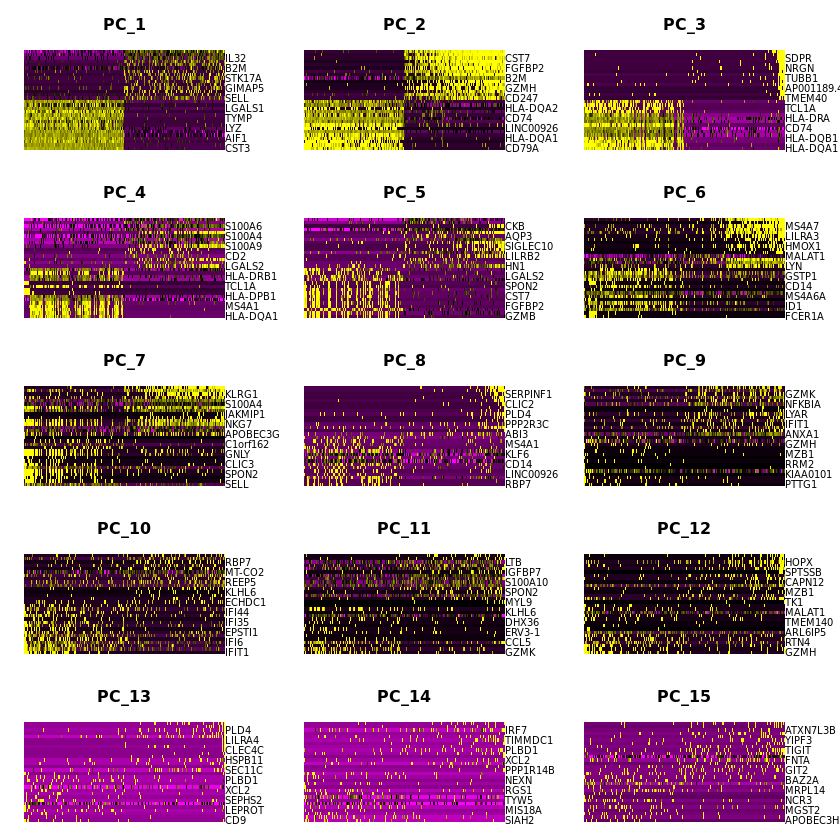

In [31]:
# Showing expression for the first two PCs.
VizDimLoadings(pbmc_filtered, dims = 1:2, reduction = "pca")
#DimPlot(pbmc_filtered, reduction = "pca") + NoLegend()
DimHeatmap(pbmc_filtered, dims = 1:15, cells = 500, balanced = TRUE)

<h5>Determine dimensionality of dataset</h5>
We will be using Seurat's convenient "Elbow plot" function to explain and rank principle components (https://satijalab.org/seurat/reference/elbowplot)

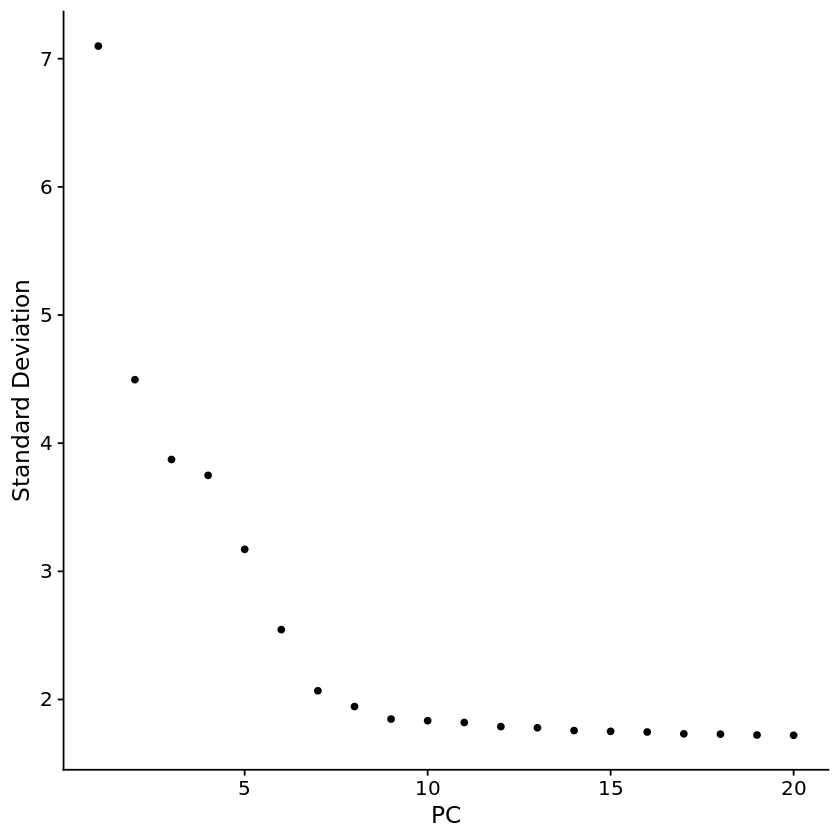

In [32]:
#Visualize variance. The plot seems to suggest most of the significance can be attributed to PCs 1-10
ElbowPlot(pbmc_filtered)

<h5>Cluster cells</h5>
Using the previously determined 10 dimensions as an input, a KNN graph based on the euclidian distance in PCA space is constructed. Then, the cells are clustered according to the Louvain algorithm.

In [33]:
pbmc_filtered <- FindNeighbors(pbmc_filtered, dims = 1:10)
pbmc_filtered <- FindClusters(pbmc_filtered, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95965

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8723
Number of communities: 9
Elapsed time: 0 seconds


<h5>UMAP/tSNE</h5>
Similar cells are visualized in clusters. Cluster IDs can be identified according to the following chart.

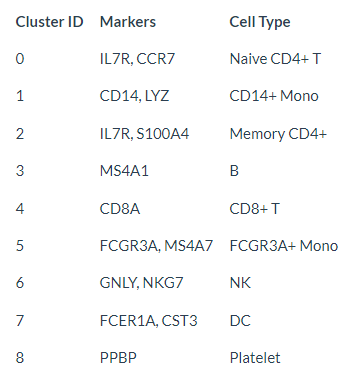


18:01:28 UMAP embedding parameters a = 0.9922 b = 1.112

18:01:28 Read 2638 rows and found 10 numeric columns

18:01:28 Using Annoy for neighbor search, n_neighbors = 30

18:01:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:01:28 Writing NN index file to temp file /tmp/RtmpkYEfp4/file558f214cd7902

18:01:28 Searching Annoy index using 1 thread, search_k = 3000

18:01:29 Annoy recall = 100%

18:01:29 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

18:01:29 Initializing from normalized Laplacian + noise (using RSpectra)

18:01:29 Commencing optimization for 500 epochs, with 105124 positive edges

18:01:32 Optimization finished



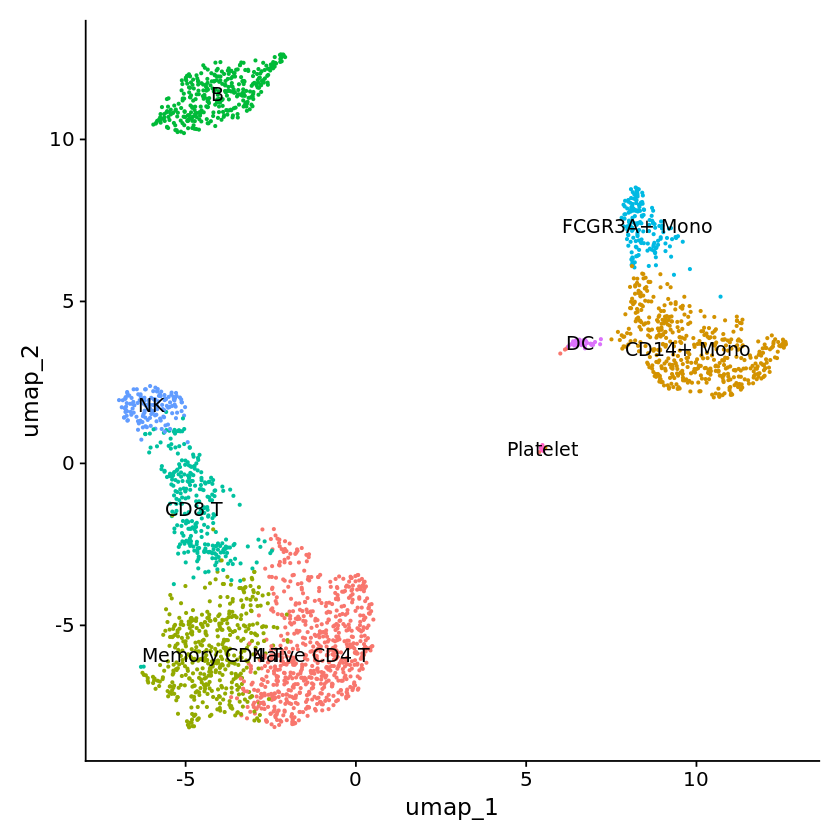

In [34]:
pbmc_filtered <- RunUMAP(pbmc_filtered, dims = 1:10)
# Create ID vector
new.cluster.ids <- c("Naive CD4 T", "CD14+ Mono", "Memory CD4 T", "B", "CD8 T", "FCGR3A+ Mono",
    "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc_filtered)
pbmc_filtered <- RenameIdents(pbmc_filtered, new.cluster.ids)
DimPlot(pbmc_filtered, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

<h5>Finding differentially expressed features (cluster biomarkers)</h5>
You can optionally install the presto package to greatly increase speeds. However, FindMarkers will function without it.

In [35]:
# find all markers of cluster 
cluster_cd4_mem.markers <- FindMarkers(pbmc_filtered, ident.1 = "Memory CD4 T")
head(cluster_cd4_mem.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IL32,2.593535e-91,1.3221171,0.949,0.466,3.556774e-87
LTB,7.994465e-87,1.3450377,0.981,0.644,1.096361e-82
CD3D,3.922451e-70,1.0562099,0.922,0.433,5.379250e-66
IL7R,1.130870e-66,1.4256944,0.748,0.327,1.550876e-62
LDHB,4.082189e-65,0.9765875,0.953,0.614,5.598314e-61


In [36]:
# find all markers distinguishing cluster FCGR3A+ Mono (5) from clusters Naive CD4+ T (0) and B (3)
cluster_fcgr_mono.markers <- FindMarkers(pbmc_filtered, ident.1 = "FCGR3A+ Mono", ident.2 = c("Naive CD4 T", "B"))
head(cluster_fcgr_mono.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,2.150929e-209,6.832372,0.975,0.039,2.949784e-205
IFITM3,6.103366e-199,6.181000,0.975,0.048,8.370156e-195
CFD,8.891428e-198,6.052575,0.938,0.037,1.219370e-193
CD68,2.374425e-194,5.493138,0.926,0.035,3.256286e-190
RP11-290F20.3,9.308287e-191,6.335402,0.840,0.016,1.276538e-186


In [37]:
# find markers for every cluster compared to all remaining cells, report only the positive
# ones
pbmc_filtered.markers <- FindAllMarkers(pbmc_filtered, only.pos = TRUE)
pbmc_filtered.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1)

Calculating cluster Naive CD4 T

Calculating cluster CD14+ Mono

Calculating cluster Memory CD4 T

Calculating cluster B

Calculating cluster CD8 T

Calculating cluster FCGR3A+ Mono

Calculating cluster NK

Calculating cluster DC

Calculating cluster Platelet



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.740957e-109,1.189519,0.897,0.593,2.387549e-105,Naive CD4 T,LDHB
1.167632e-83,2.369020,0.435,0.108,1.601290e-79,Naive CD4 T,CCR7
8.939451e-79,1.086580,0.838,0.403,1.225956e-74,Naive CD4 T,CD3D
3.053170e-53,1.018288,0.722,0.399,4.187117e-49,Naive CD4 T,CD3E
3.284150e-49,2.096128,0.333,0.103,4.503883e-45,Naive CD4 T,LEF1
6.656031e-49,1.247660,0.623,0.358,9.128080e-45,Naive CD4 T,NOSIP
9.308520e-44,2.016613,0.328,0.110,1.276570e-39,Naive CD4 T,PRKCQ-AS1
4.688674e-43,1.525023,0.435,0.184,6.430048e-39,Naive CD4 T,PIK3IP1
1.468627e-39,2.702477,0.195,0.040,2.014074e-35,Naive CD4 T,FHIT


You can visualize cluster expression through violin plots

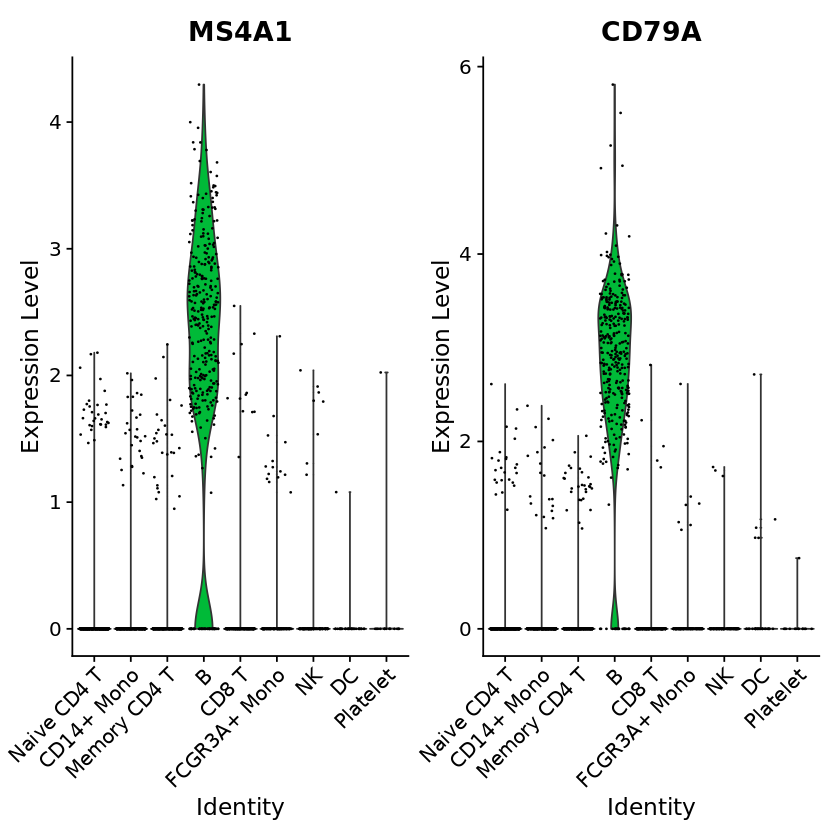

In [38]:
VlnPlot(pbmc_filtered, features = c("MS4A1", "CD79A"))

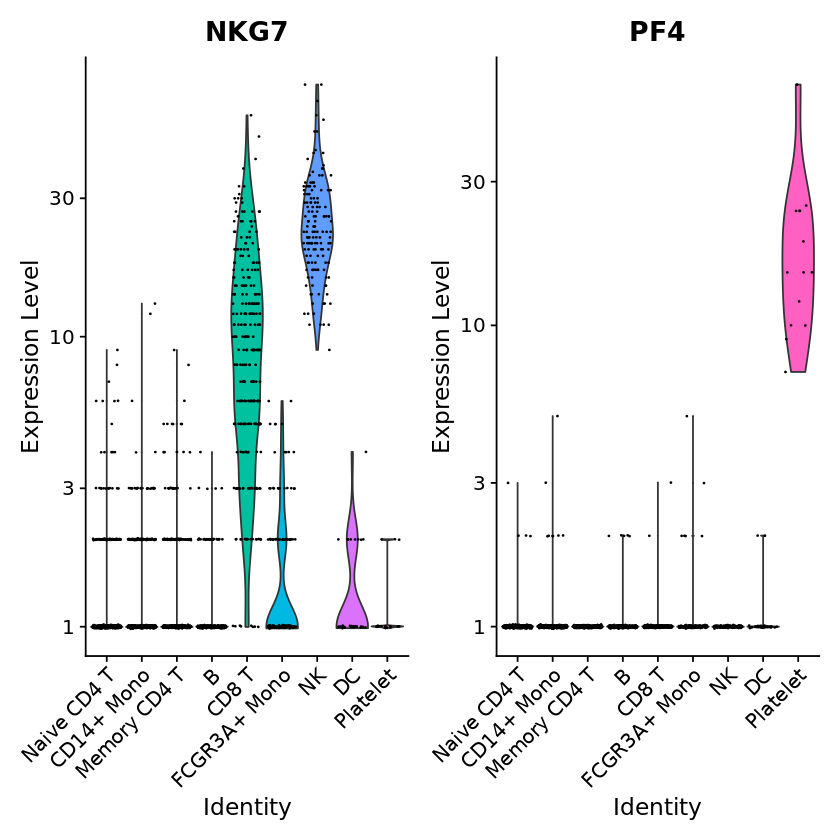

In [39]:
# plot raw counts
VlnPlot(pbmc_filtered, features = c("NKG7", "PF4"), slot = "counts", log = TRUE)

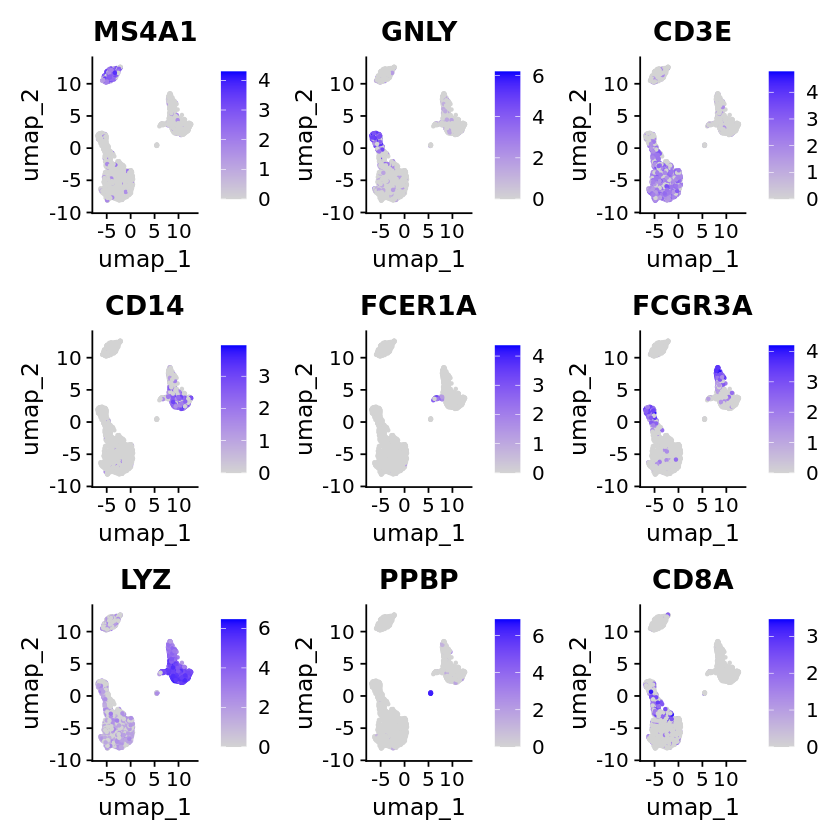

In [40]:
FeaturePlot(pbmc_filtered, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP",
    "CD8A"))

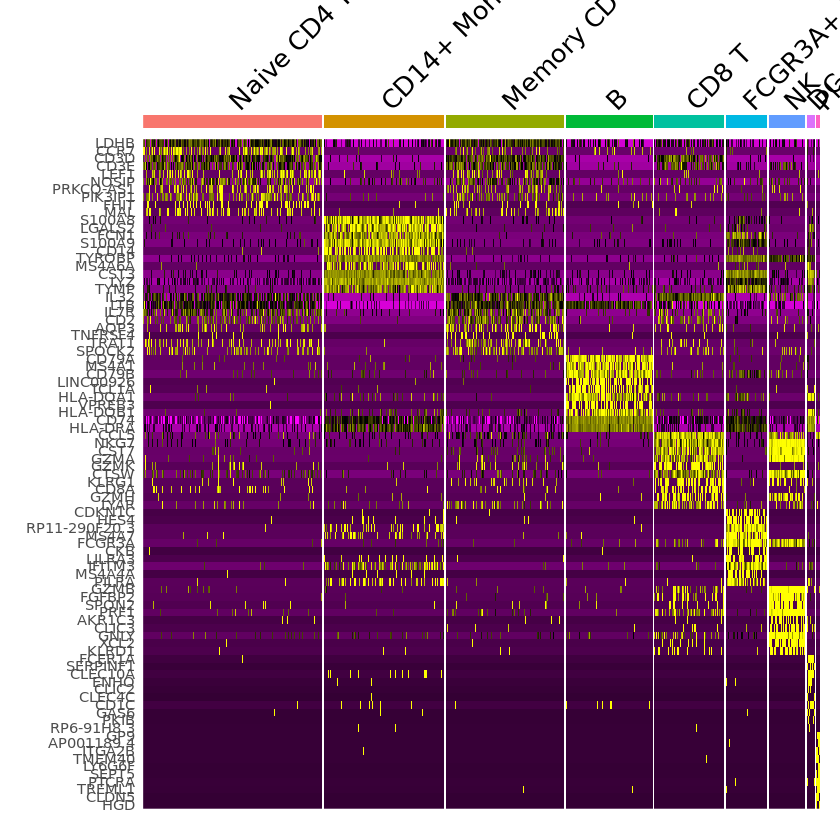

In [41]:
# Visualize feature expression across all clusters
pbmc_filtered.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1) %>%
    slice_head(n = 10) %>%
    ungroup() -> top10
DoHeatmap(pbmc_filtered, features = top10$gene) + NoLegend()